## 2.1 Problem statement

How can healthcare providers predict heart failure with > 85% accuracy among individuals when their medical records are available?

## 2.2 Context

Cardiovascular diseases (CVDs) led to nearly 17.9 million deaths in 2019, which account for 32% of all global deaths. Nearly 85% of them were because of heart attack and stroke. Several health issues may serve as precursors to CVDs and heart failure/stroke. A model that can predict heart failure in patients can lead to early management of the problem and help in reducing the mortality rate.

More information is available here: https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

## 2.3 Criteria for success

Given the medical record of an individual, predict heart failure with > 85% accuracy.

## 2.4 Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

## 2.5 Load patient data

In [2]:
df = pd.read_csv('heart.csv')

## 2.6 Data Definition

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


This dataset is relatively clean as there are no missing values. We need to take a closer look for a better understanding of numerical and categorical features.

### 2.6.1. Attribute information

1. Age: age of the patient [years]


2. Sex: sex of the patient [M: Male, F: Female]


3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]


4. RestingBP: resting blood pressure [mm Hg]


5. Cholesterol: serum cholesterol [mm/dl]


6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]


7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]


8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]


9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]


10. Oldpeak: oldpeak = ST [Numeric value measured in depression]


11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]


12. HeartDisease: output class [1: heart disease, 0: Normal]

### 2.6.2 Numerical features

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


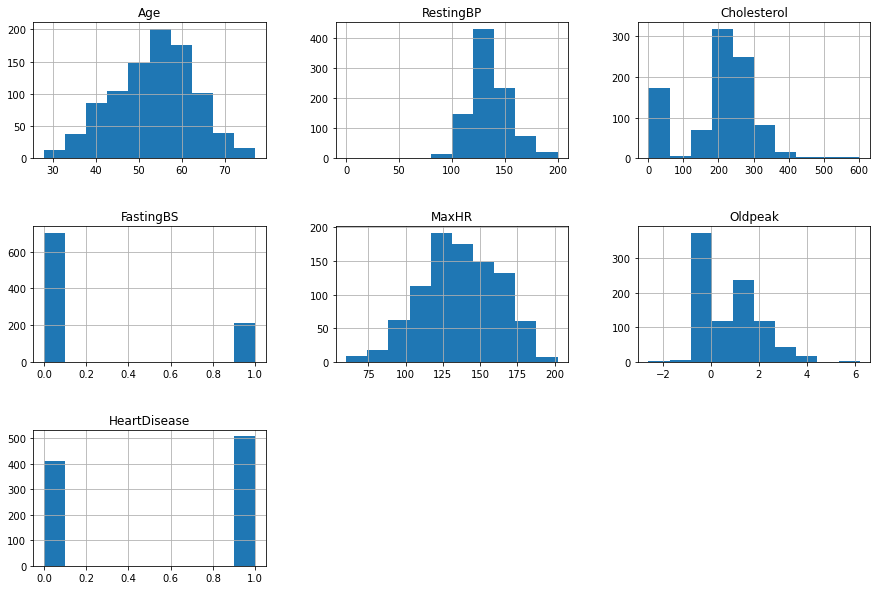

In [6]:
# Plot histograms of numerical features to understand their distribution

df.hist(figsize = (15,10))
plt.subplots_adjust(hspace=0.5);

### 2.6.2.1 Observations


These tables show some interesting facts about the patients whose medical records are collected.


1. Age - it seems that majority of the patients are over 40 years old, and the oldest one is 77 years old. This trend makes sense as older people are more susceptible to heart diseases.


2. RestingBP - desired resting blood pressure level is ~120. Majority of the patients have high blood pressure. However, there are many cases with BP > 150, which is a concern.


3. Cholesterol - cholesterol levels of < 200 are desirable for adults. Majority of the patients have high cholesterol.


4. FastingBS - nearly 20% of the patients have blood sugar > 120 md/dl, which means they are diabetic.


5. MaxHR - desired maximum heart rate depends on the person's age. A table of maximum heart rate for various age groups can be found here: https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates. When compared with this table, many patients stand out with low MaxHR (<100). How these measurements were made is not clear. Thus, their accuracy may be questionable. This is something we should keep in mind while analyzing the data further. Instead of using MaxHR as a numerical variable, it may be more appropriate to check if the patient's maximum heart rate is lower than the specified limit for their age group. This conversion will be performed in the next section.


6. Oldpeak - occurrence of ST depression (Oldpeak < 0) is particularly associated with heart disease. However, ST elevation (Oldpeak > 0) is also associated with several medical conditions that may contribute to heart failure.


7. HeartDisease - about 55% of the patients are diagnosed with heart disease. Thus, this is a reasonably balanced data set. A random and large enough sample should be representative of the entire data. 

### 2.6.3 Categorical features

In [7]:
# Select only categorical features from the data

df.select_dtypes(include = 'object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


<AxesSubplot:>

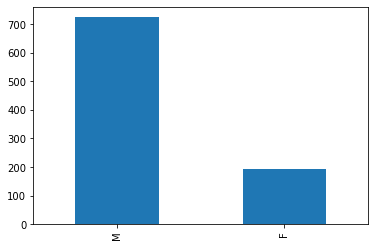

In [8]:
# Find the number of Male and Female patients

df['Sex'].value_counts().plot(kind = 'bar')

Men account for nearly 80% of the total patients as they are in general more susceptible to heart diseases than women.

<AxesSubplot:>

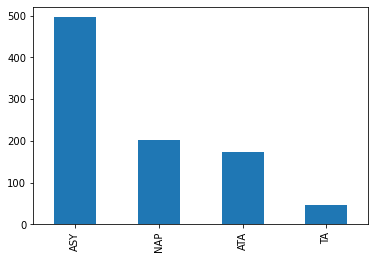

In [9]:
# Find chest paint types

df['ChestPainType'].value_counts().plot(kind = 'bar')

More than 50% of the patients show no chest pain. This means there may be a significant overlap between a patient showing chest pain and having a heart disease. This relationship needs to be tested further.

<AxesSubplot:>

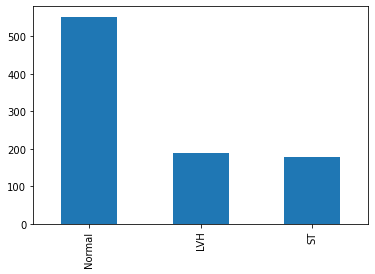

In [10]:
# Find resting ECG types

df['RestingECG'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

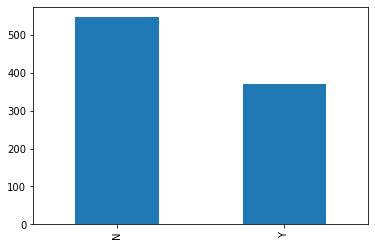

In [11]:
# Exercise Angina occurrences

df['ExerciseAngina'].value_counts().plot(kind = 'bar')

In the case of resting ECG and exercise Angina tests, ~ 55% patients show normal behavior. The correlation of these factors with heart disease diagnosis will be tested further.

<AxesSubplot:>

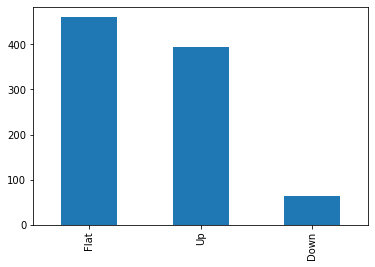

In [12]:
# ST slope analysis

df['ST_Slope'].value_counts().plot(kind = 'bar')

ST segment slope should be slightly up (>0) in case of normal patients, while flat (slope ~0) or downward (slope < 0) ST segments indicate heart disease. Since a small fraction of patients show downward slope, it may be beneficial to combine the 'flat' and 'downard' categories to simplify the predictor model.

## 2.7 Data cleaning

In [16]:
# Look for duplicated records

df.duplicated().sum()

0

There are no duplicated records.

In [22]:
# Convert MAxHR into categorical variable based on agewise maximum heart rate
# Build a function that takes 'Age' and 'MaxHR' as inputs and return '0' if MaxHR is less than or equal to recommended value
# and '1' if MaxHR is greater than the recommended value

def HR_converter(age, maxhr):
    if age <= 25:
        if maxhr <= 200:
            return 0
        else: return 1
    elif age <= 33:
        if maxhr <= 190:
            return 0
        else: return 1
    elif age <= 38:
        if maxhr <= 185:
            return 0
        else: return 1
    elif age <= 43:
        if maxhr <= 180:
            return 0
        else: return 1
    elif age <= 48:
        if maxhr <= 175:
            return 0
        else: return 1
    elif age <= 53:
        if maxhr <= 170:
            return 0
        else: return 1
    elif age <= 58:
        if maxhr <= 165:
            return 0
        else: return 1
    elif age <= 63:
        if maxhr <= 160:
            return 0
        else: return 1
    elif age <= 68:
        if maxhr <= 155:
            return 0
        else: return 1
    else:
        if maxhr <= 150:
            return 0
        else: return 1


In [29]:
# Apply 'HR_converter' function to the dataframe

df['MaxHRCat'] = df.apply(lambda x: HR_converter(age = x['Age'], maxhr = x['MaxHR']), axis=1)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,MaxHRCat
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0


In [30]:
# Convert ST_slope into categorical variable based on normal and abnormal slope values
# Build a function that returns '0' if ST_slope is 'Up', otherwise returns '1'

def slope_converter(slope):
    try:
        if slope == 'Up':
            return 0
        elif slope == 'Flat':
            return 1
        elif slope == 'Down':
            return 1
    except ValueError:
        print('Please enter a valid indicator')

In [39]:
df['ST_SlopeCat'] = df.apply(lambda x: slope_converter(slope = x['ST_Slope']), axis=1)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,MaxHRCat,ST_SlopeCat
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0,0


Other categorical variables have not been transformed yet. This step will be taken once the choice of regressor / classifier is decided.

In [40]:
# Save data in a new '.csv' file

df.to_csv('heart_wrangling.csv')